# House Prices - Data Preprocessing & Modeling

Greetings! In this notebook we will take what we have learned from earlier EDA and continue into data preprocessing. During this process, we will fit some baseline models to make sure we're on the right track.

Once the data has been cleaned, we will evaluate a variety of different models and perform hyperparameter optimization.

So, based on earlier EDA, we know:

* There are a lot of missing values in the data -> need to process
* There are also duplicative (highly-correlated) features that add no extra value) -> our dataset is a candidate for regularization
* `Id` can probably be safely deleted as it is simply a auto-incrementing label for each observation -> delete this feature
* The target variable, `SalePrice`, is right skewed -> apply a log-transformation
* Other numeric variables may also be right skewed -> apply a log-transformation when skew is greater than our threshold

Let's get started.

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from datetime import datetime

SEED = 42

# Prevent Pandas from truncating displayed dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]

**Load the Data**

In [2]:
train_ = pd.read_csv("assets/train.csv")
test_ = pd.read_csv("assets/test.csv")
submission = pd.read_csv("assets/sample_submission.csv")

# Prepare our base training/test data
train = train_.copy().drop(columns="Id")
test = test_.copy().drop(columns="Id")

In [3]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Create Helper Functions**

In [4]:
def rmse_cv(model, X, y):
    """Return the cross validated RMSE scores for a given model, training data and target data."""
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [5]:
def generate_output(preds, save=False):
    """Collate predicted values into an output file and save as .csv."""
    output = submission.copy()
    output["SalePrice"] = preds
    
    if save:
        date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
        output.to_csv("submissions/submission-"+date_time+".csv", index=False)
    return output

In [6]:
def plot_coefs(model, X):
    """Display top 10 positive and top 10 negative model coefficients in a bar chart."""
    fig, ax = plt.subplots()
    coefs = pd.Series(model.coef_, index=X.columns)
    important_coefs = pd.concat([coefs.sort_values().head(10), coefs.sort_values().tail(10)])
    sns.barplot(x=important_coefs, y=important_coefs.index, orient='h', ax=ax)
    ax.grid()
    plt.title("Top 20 Coefficients - Regularized Regression Model")
    plt.tight_layout()
    plt.show()

**Deal with Missing Values**

Models don't do well with missing values. We'll need to perform substitutions or drop observations/features to remove all missing values from the data.

First, let's get a sense of how many missing values we have.

In [7]:
temp = pd.concat([train.drop(columns="SalePrice"), test])
nulls = temp.isnull().sum()[temp.isnull().sum() > 0].sort_values(ascending=False).to_frame().rename(columns={0: "MissingVals"})
nulls["MissingValsPct"] = nulls["MissingVals"] / len(temp)
nulls.head()

,MissingVals,MissingValsPct
PoolQC,2909,0.996574
MiscFeature,2814,0.964029
Alley,2721,0.932169
Fence,2348,0.804385
FireplaceQu,1420,0.486468


By using the data description .txt file (`ctrl`+`f` is your friend), we can make sensible choices with regards to filling missing values. However, in some cases, we have to use our best judgement, as it's not 100% black or white.

In [8]:
# Very helpful: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

for df in [train, test]:
    ## EASIER TO HANDLE:
    
    # PoolQC -> data description says NA = No Pool
    df["PoolQC"].fillna(value="None", inplace=True)
    # MiscFeature -> data description says NA = None
    df["MiscFeature"].fillna(value="None", inplace=True)
    # Alley -> data description says NA = No alley access
    df["Alley"].fillna(value="None", inplace=True)
    # Fence -> data description says NA = No fence
    df["Fence"].fillna(value="None", inplace=True)
    # FireplaceQu -> data description says NA = No fireplace
    df["FireplaceQu"].fillna(value="None", inplace=True)
    # Garage features -> data description says NA = No garage
    df["GarageType"].fillna(value="None", inplace=True)
    df["GarageFinish"].fillna(value="None", inplace=True)
    df["GarageQual"].fillna(value="None", inplace=True)
    df["GarageCond"].fillna(value="None", inplace=True)
    df["GarageArea"].fillna(value=0, inplace=True)
    df["GarageCars"].fillna(value=0, inplace=True)
    # Basement features -> data description says NA = No garage
    df["BsmtCond"].fillna(value="None", inplace=True)
    df["BsmtExposure"].fillna(value="None", inplace=True)
    df["BsmtQual"].fillna(value="None", inplace=True)
    df["BsmtFinType1"].fillna(value="None", inplace=True)
    df["BsmtFinSF1"].fillna(value=0, inplace=True)
    df["BsmtFinType2"].fillna(value="None", inplace=True)
    df["BsmtFinSF2"].fillna(value=0, inplace=True)
    df["TotalBsmtSF"].fillna(value=0, inplace=True)
    df["BsmtUnfSF"].fillna(value=0, inplace=True)
    df["BsmtFullBath"].fillna(value=0, inplace=True)
    df["BsmtHalfBath"].fillna(value=0, inplace=True)
    # Functional -> data description says assume typical
    df["Functional"].fillna(value="Typ", inplace=True)
    
    ## LESS CLEAR:
    
    # LotFrontage -> assume median
    df["LotFrontage"].fillna(value=df["LotFrontage"].median(), inplace=True)
    # GarageYrBlt -> assume equal to YearBuilt
    df["GarageYrBlt"].fillna(value=df["YearBuilt"], inplace=True)
    # MasVnrType -> NA most likely means no masonry veneer
    df["MasVnrType"].fillna(value="None", inplace=True)
    df["MasVnrArea"].fillna(value=0, inplace=True)
    # Utilities -> assume the mode
    df["Utilities"].fillna(value=df["Utilities"].mode()[0], inplace=True)
    # SaleType -> assume the mode
    df["SaleType"].fillna(value=df["SaleType"].mode()[0], inplace=True)
    # KitchenQual -> assume the mode
    df["KitchenQual"].fillna(value=df["KitchenQual"].mode()[0], inplace=True)
    # Electrical -> assume the mode
    df["Electrical"].fillna(value=df["Electrical"].mode()[0], inplace=True)    
    # MSZoning -> assume the mode
    df["MSZoning"].fillna(value=df["MSZoning"].mode()[0], inplace=True)  
    # Exterior1st -> assume the mode
    df["Exterior1st"].fillna(value=df["Exterior1st"].mode()[0], inplace=True)  
    # Exterior2nd -> assume the mode
    df["Exterior2nd"].fillna(value=df["Exterior2nd"].mode()[0], inplace=True)

When filling NAs, it can be helpful to plot the mean and the median alongside the feature's distribution. This can help illustrate when the mean is impacted by outliers and when it is better to fill NAs with the median.

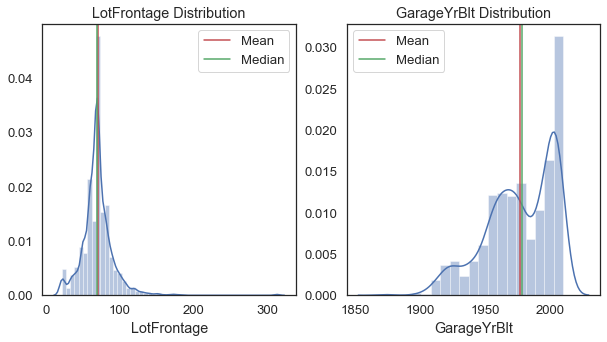

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

sns.distplot(train["LotFrontage"].dropna(), ax=ax[0])
ax[0].axvline(x=train["LotFrontage"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[0].axvline(x=train["LotFrontage"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[0].legend()
ax[0].set_title("LotFrontage Distribution")


sns.distplot(train["GarageYrBlt"].dropna(), ax=ax[1])
ax[1].axvline(x=train["GarageYrBlt"].mean(), ymin=0, ymax=1, color='r', label="Mean")
ax[1].axvline(x=train["GarageYrBlt"].median(), ymin=0, ymax=1, color='g', label="Median")
ax[1].legend()
ax[1].set_title("GarageYrBlt Distribution")

plt.show()

**Convert Select Numeric Features to Categorical Features**

Some of the numerical features are actually categorical. Let's fix them.

In [10]:
# By making these substitutions, the columns are automatically cast to datatype object
for df in [train, test]:
    df.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                               50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                               80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                               150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                               7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      }, inplace=True)

**Remove/Fix Outliers**

There are potentially many outliers in the data, however, here, I will address only what I see as the biggest offenders. 

First, the `GrLivArea` outliers that are mentioned in the [author's original paper](http://jse.amstat.org/v19n3/decock.pdf) on pg. 4; let's follow the author's advice and remove the unusual homes that are more than 4000 square feet.

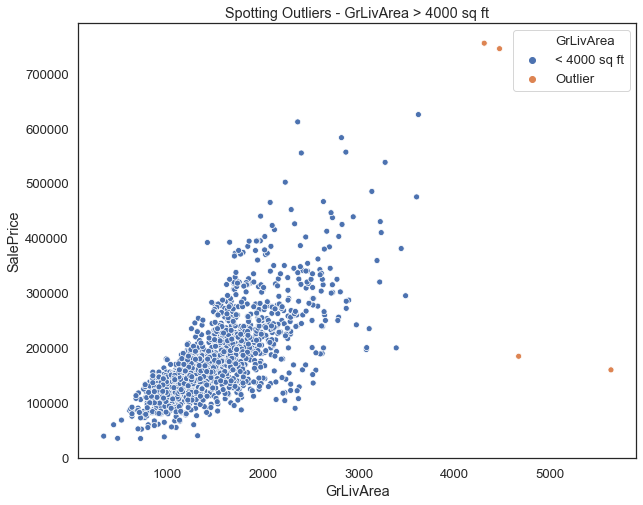

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,SC60,RL,130.0,40094,Pave,None,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,None,None,None,0,Oct,2007,New,Partial,184750
691,SC60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,6,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1455,Unf,0,989,2444,GasA,Ex,Y,SBrkr,2444,1872,0,4316,0,1,3,1,4,1,Ex,10,Typ,2,Ex,Attchd,1994.0,Fin,3,832,TA,TA,Y,382,50,0,0,0,0,None,None,None,0,Jan,2007,WD,Normal,755000
1182,SC60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1996,1996,Hip,CompShg,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,Ex,TA,Av,GLQ,2096,Unf,0,300,2396,GasA,Ex,Y,SBrkr,2411,2065,0,4476,1,0,3,1,4,1,Ex,10,Typ,2,TA,Attchd,1996.0,Fin,3,813,TA,TA,Y,171,78,0,0,0,555,Ex,MnPrv,None,0,Jul,2007,WD,Abnorml,745000
1298,SC60,RL,313.0,63887,Pave,None,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,None,None,0,Jan,2008,New,Partial,160000


In [11]:
mask = train["GrLivArea"] > 4000
mask = mask.replace(to_replace=[1, 0], value=["Outlier", "< 4000 sq ft"])
sns.scatterplot(x=train["GrLivArea"], y=train["SalePrice"], hue=mask)
plt.title("Spotting Outliers - GrLivArea > 4000 sq ft")
plt.show()

train[train["GrLivArea"] > 4000]

In [12]:
# Remove GrLivArea outliers
train = train.drop([523, 691, 1182, 1298])

Next, let's fix the `GarageYrBlt` value for one particular house in the test set by assuming that 2207 is supposed to be 2007.

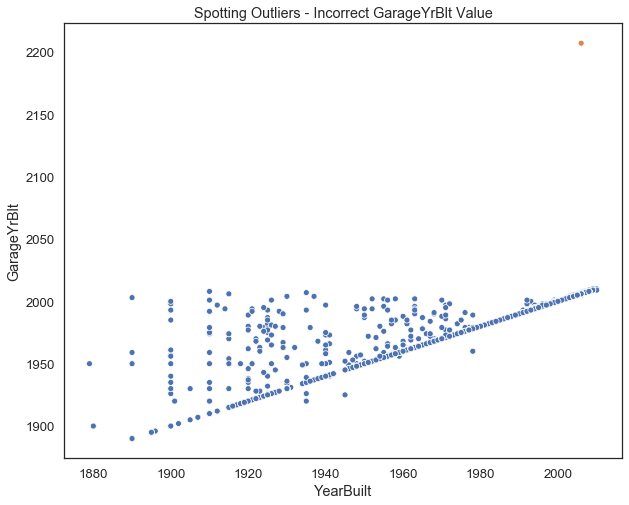

In [13]:
mask = test["GarageYrBlt"] == 2207
sns.scatterplot(x=test["YearBuilt"], y=test["GarageYrBlt"], hue=mask, legend=False)
plt.title("Spotting Outliers - Incorrect GarageYrBlt Value")
plt.show()

In [14]:
# Assume that 2207 was meant to be 2007
test.loc[test["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007

**Feature Engineering**

Feature engineering allows us to create new features using existing data.

In [15]:
for df in [train, test]:
    df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

**Bucketing Features**

It's important that we handle each different type of feature correctly:

* Ordinal features: replace with ordered labels
* Categorical features: one-hot encode
* Numeric features: correct for skew and scale

In [16]:
numeric_features = np.array([c for c in train.select_dtypes(include=[np.number]).columns if c != "SalePrice"])
numeric_features

array(['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold',
       'TotalSF'], dtype='<U13')

In [17]:
categorical_features = np.array(train.select_dtypes(include=[np.object]).columns)
categorical_features

array(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'MoSold', 'SaleType', 'SaleCondition'], dtype=object)

In [18]:
ordinal_features = ["ExterQual", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", 
                "LandSlope", "ExterCond", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", 
                "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "LotShape", "Utilities"]
nominal_features = list(set(categorical_features) - set(ordinal_features))

**LabelEncode the Ordinal Features**

Using the data description file, we can determine which categorical columns refer to ordinal characteristics and replace feature values with ordered numbers. The reason we choose to do this manually (and don't use something like LabelEncoder) is because we want to be able to control the ordering of features, i.e. be able to specify which value corresponds with 0, which value corresponds with 1 etc.

In [19]:
for df in [train, test]:
    df.replace({"BsmtCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "BsmtExposure" : {"None" : 0, "No": 0, "Mn" : 1, "Av": 2, "Gd" : 3},
               "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
               "BsmtQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
               "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
               "FireplaceQu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, "Min2" : 6, "Min1" : 7, "Typ" : 8},
               "GarageCond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageQual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "GarageFinish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
               "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
               "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
               "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
               "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
               "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                , inplace=True)
    
    df[ordinal_features] = df[ordinal_features].astype('int64')

**One-Hot Encode the Nominal Features**

In [20]:
nominal_data = pd.concat([train[nominal_features], test[nominal_features]])
nominal_data.head()

,MiscFeature,Street,CentralAir,Condition1,LotConfig,LandContour,RoofStyle,Exterior2nd,Foundation,Fence,PavedDrive,Condition2,SaleType,RoofMatl,Exterior1st,MoSold,Electrical,HouseStyle,Heating,Alley,BldgType,MSSubClass,GarageType,Neighborhood,MasVnrType,SaleCondition,MSZoning
0,None,Pave,Y,Norm,Inside,Lvl,Gable,VinylSd,PConc,None,Y,Norm,WD,CompShg,VinylSd,Feb,SBrkr,2Story,GasA,None,1Fam,SC60,Attchd,CollgCr,BrkFace,Normal,RL
1,None,Pave,Y,Feedr,FR2,Lvl,Gable,MetalSd,CBlock,None,Y,Norm,WD,CompShg,MetalSd,May,SBrkr,1Story,GasA,None,1Fam,SC20,Attchd,Veenker,None,Normal,RL
2,None,Pave,Y,Norm,Inside,Lvl,Gable,VinylSd,PConc,None,Y,Norm,WD,CompShg,VinylSd,Sep,SBrkr,2Story,GasA,None,1Fam,SC60,Attchd,CollgCr,BrkFace,Normal,RL
3,None,Pave,Y,Norm,Corner,Lvl,Gable,Wd Shng,BrkTil,None,Y,Norm,WD,CompShg,Wd Sdng,Feb,SBrkr,2Story,GasA,None,1Fam,SC70,Detchd,Crawfor,None,Abnorml,RL
4,None,Pave,Y,Norm,FR2,Lvl,Gable,VinylSd,PConc,None,Y,Norm,WD,CompShg,VinylSd,Dec,SBrkr,2Story,GasA,None,1Fam,SC60,Attchd,NoRidge,BrkFace,Normal,RL


In [21]:
train.shape, test.shape, nominal_data.shape

((1456, 81), (1459, 80), (2915, 27))

In [22]:
nominal_data = pd.get_dummies(nominal_data)
nominal_data.head()

,MiscFeature_Gar2,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,Street_Grvl,Street_Pave,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Fence_GdPrv,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_None,PavedDrive_N,PavedDrive_P,PavedDrive_Y,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,MoSold_Apr,MoSold_Aug,MoSold_Dec,MoSold_Feb,MoSold_Jan,MoSold_Jul,MoSold_Jun,MoSold_Mar,MoSold_May,MoSold_Nov,MoSold_Oct,MoSold_Sep,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,Heating_Floor,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,Alley_Grvl,Alley_None,Alley_Pave,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,MSSubClass_SC120,MSSubClass_SC150,MSSubClass_SC160,MSSubClass_SC180,MSSubClass_SC190,MSSubClass_SC20,MSSubClass_SC30,MSSubClass_SC40,MSSubClass_SC45,MSSubClass_SC50,MSSubClass_SC60,MSSubClass_SC70,MSSubClass_SC75,MSSubClass_SC80,MSSubClass_SC85,MSSubClass_SC90,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM
0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0
1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,

In [23]:
train_dummies = nominal_data[:train.shape[0]]
test_dummies = nominal_data[train.shape[0]:]
train_dummies.shape, test_dummies.shape

((1456, 204), (1459, 204))

Join the dummy columns with the numeric and ordinal columns:

In [24]:
y = train["SalePrice"]
train = pd.concat([train[numeric_features], train[ordinal_features], train_dummies], axis=1)
test = pd.concat([test[numeric_features], test[ordinal_features], test_dummies], axis=1)

Verify that we have extracted the correct number of rows for train vs. test. Also make sure that we have the same columns in both sets.

In [25]:
train.shape, test.shape

((1456, 257), (1459, 257))

In [26]:
set(train.columns) - set(test.columns)

set()

**Log-Transform Skewed Numeric Variables**

I read in a few different places that a |skew| > 0.5 is considered "moderately skewed" and have chosen this as my threshold. If you have any input, please leave a comment below.

In [27]:
y = np.log1p(y) # SalePrice
skew_threshold = 0.5 # As a general rule of thumb, |skew| > 0.5 is considered moderately skewed

for df in [train[numeric_features], test[numeric_features]]:
    skewness = df.apply(lambda x: stats.skew(x))
    skewness = skewness[np.abs(skewness) > skew_threshold]
    skewed_cols = skewness.index
    log_transformed_cols = np.log1p(df[skewed_cols])
    df[skewed_cols] = log_transformed_cols
    print("Transforming {} features...".format(len(skewed_cols)))

train[numeric_features] = train[numeric_features].astype('int64')
test[numeric_features] = test[numeric_features].astype('int64')

Transforming 27 features...
Transforming 27 features...


D:\PROGRAMS\Anaconda\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Baseline Model using Numeric Data Only**

In [28]:
np.linspace(2**(-7), 2**3, num=10)

array([7.81250000e-03, 8.95833333e-01, 1.78385417e+00, 2.67187500e+00,
       3.55989583e+00, 4.44791667e+00, 5.33593750e+00, 6.22395833e+00,
       7.11197917e+00, 8.00000000e+00])

In [29]:
def compare_ridge_lasso(X, y):
    plt.figure(figsize=(5,5))
    alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 40, 50, 75]
    cv_ridge = [rmse_cv(Ridge(alpha=alpha), X, y).mean() for alpha in alphas]
    cv_ridge = pd.Series(cv_ridge, index=alphas)
    best_alpha_ridge = alphas[np.argmin(cv_ridge.values)]
    sns.lineplot(x=alphas, y=cv_ridge)
    plt.title("Ridge Regression - Alpha Optimization")
    plt.xlabel("Alpha")
    plt.ylabel("RMSE")

    print("Best RMSE for Ridge Regression = {:.4f} for alpha = {}".format(cv_ridge.min(), best_alpha_ridge))
    plt.show()

    plt.figure(figsize=(5,5))
    alphas = [0.0001, 0.0002, 0.00023, 0.00025, 0.00027, 0.0003, 0.00035, 0.0004, 0.00045, 0.0005, 0.00055, 0.0006, 0.0008, 0.001, 0.002, 0.005, 0.007, 0.008, 0.01, 2, 5, 10]
    cv_lasso = [rmse_cv(Lasso(alpha=alpha, tol=0.1), X, y).mean() for alpha in alphas]
    cv_lasso = pd.Series(cv_lasso, index=alphas)
    best_alpha_lasso = alphas[np.argmin(cv_lasso.values)]
    sns.lineplot(x=alphas, y=cv_lasso)
    plt.title("Lasso Regression - Alpha Optimization")
    plt.xlabel("Alpha")
    plt.ylabel("RMSE")

    print("Best RMSE for Lasso Regression = {:.4f} for alpha = {}".format(cv_lasso.min(), best_alpha_lasso))
    plt.show()
    
    return Ridge(alpha=best_alpha_ridge) if cv_ridge.min() < cv_lasso.min() else Lasso(alpha=best_alpha_lasso)

Best RMSE for Ridge Regression = 0.1294 for alpha = 5


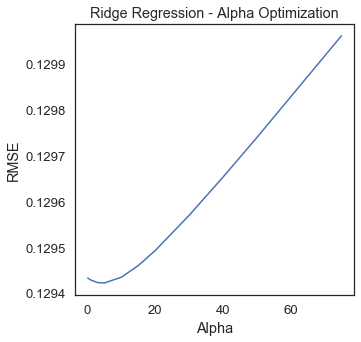

Best RMSE for Lasso Regression = 0.1309 for alpha = 0.00027


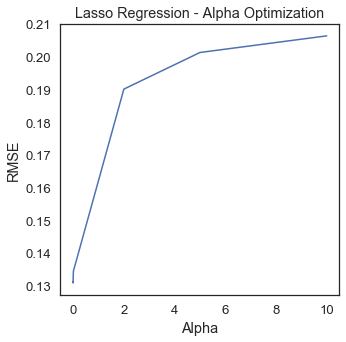

In [30]:
numeric_model = compare_ridge_lasso(train[numeric_features], y)
#0.1294, #0.1321

Generate baseline predictions using the numeric-only model:

In [31]:
numeric_model.fit(train[numeric_features], y)
predictions = np.expm1(numeric_model.predict(test[numeric_features]))
submission["SalePrice"] = predictions
predictions

array([122169.99095707, 142315.72862463, 175148.14862557, ...,
       192621.84395273, 117129.54608111, 239837.24833547])

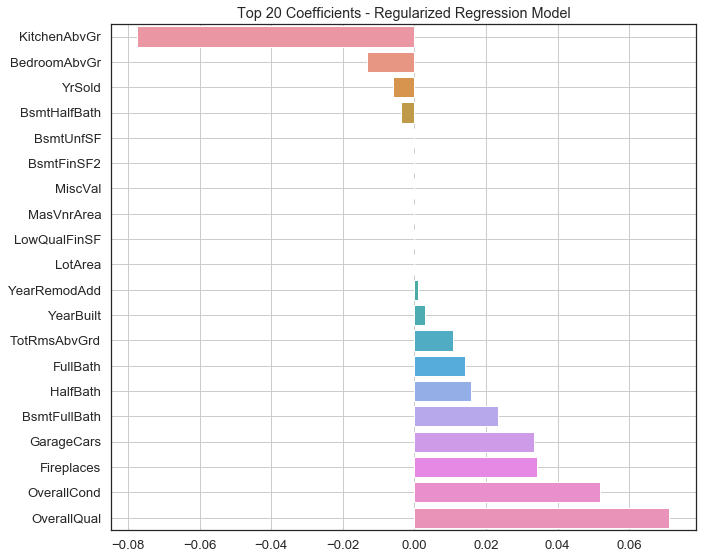

In [32]:
plot_coefs(numeric_model, train[numeric_features])

**2nd Model Using Numeric & Ordinal Features**

Best RMSE for Ridge Regression = 0.1259 for alpha = 50


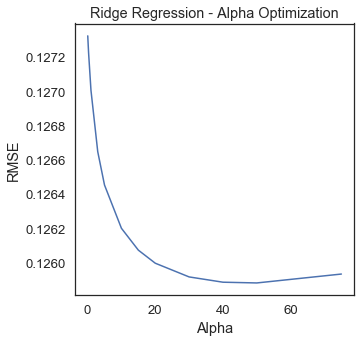

Best RMSE for Lasso Regression = 0.1289 for alpha = 0.001


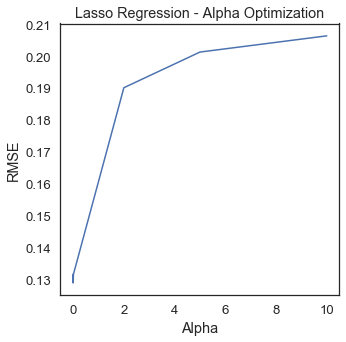

In [33]:
numeric_ordinal_features = np.append(numeric_features, ordinal_features)
model = compare_ridge_lasso(train[numeric_ordinal_features], y) # 0.1259, 0.1291
model.fit(train[numeric_ordinal_features], y)
preds = np.expm1(model.predict(test[numeric_ordinal_features]))

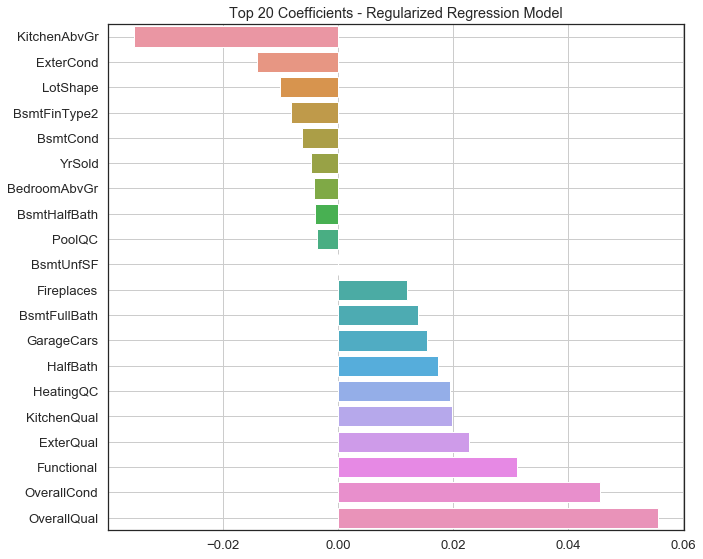

In [34]:
plot_coefs(model, train[numeric_ordinal_features])

In [35]:
output = generate_output(preds, False)
output.sort_values(by="SalePrice", ascending=False).head()

,Id,SalePrice
1089,2550,1.913501e+06
203,1664,5.805341e+05
1222,2683,5.636073e+05
514,1975,5.483617e+05
217,1678,5.383680e+05


**3rd Model Using All Features**

Best RMSE for Ridge Regression = 0.1142 for alpha = 20


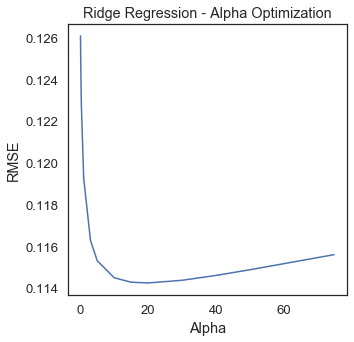

Best RMSE for Lasso Regression = 0.1210 for alpha = 0.001


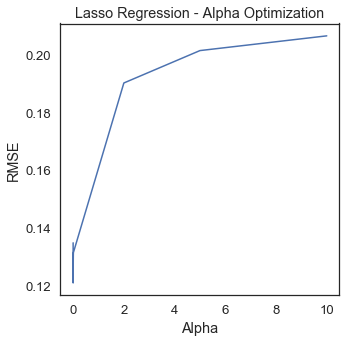

In [36]:
model = compare_ridge_lasso(train, y) # 0.1143, 0.1291
model.fit(train, y)
preds = np.expm1(model.predict(test))

In [37]:
output = generate_output(preds, False)
output.sort_values(by="SalePrice", ascending=False).head()

,Id,SalePrice
1089,2550,1.781535e+06
1222,2683,5.760647e+05
514,1975,5.596217e+05
203,1664,5.467371e+05
803,2264,5.305024e+05


**Compare Predicted Price Distribution with Training Distribution**

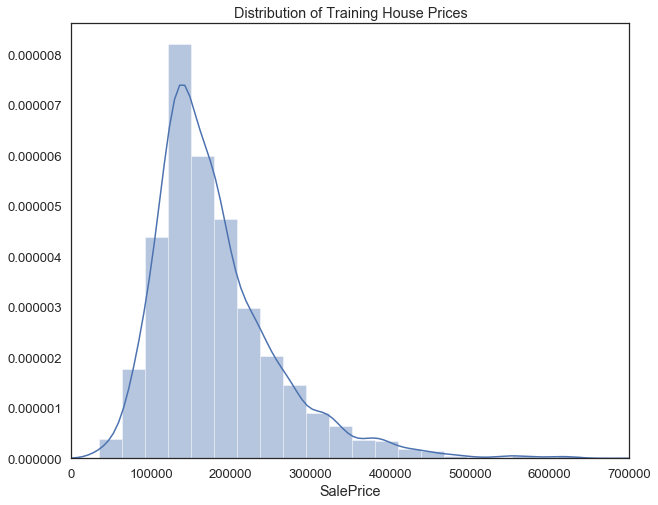

In [38]:
sns.distplot(train_["SalePrice"], bins=25)
plt.title("Distribution of Training House Prices")
plt.xlim([0,700000])
plt.show()

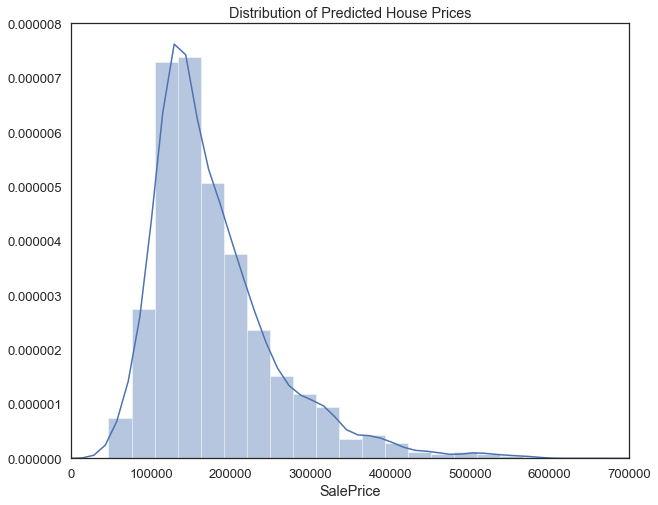

In [39]:
sns.distplot(output["SalePrice"], bins=60)
plt.title("Distribution of Predicted House Prices")
plt.xlim([0,700000])
plt.show()

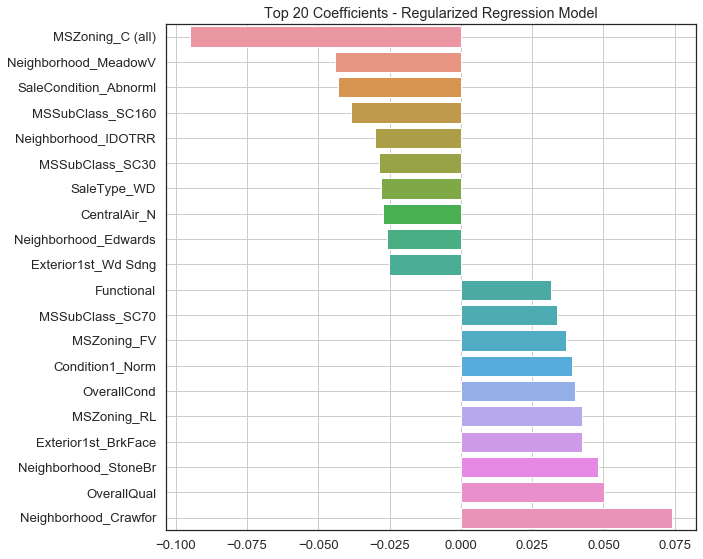

In [40]:
plot_coefs(model, train)

**Evaluate Models**

Rather than splitting the data using `train_test_split`, let's use `cross_val_score` to evaluate our models. The benefit of this approach is that each observation will be used in both train and test, which is critical when dealing with limited input data.

In [91]:
linear = LinearRegression(n_jobs=-1)
ridge = Ridge(random_state=SEED)
lasso = Lasso(random_state=SEED)
elnt = ElasticNet(random_state=SEED)
kr = KernelRidge()
svr = SVR()
knn = KNeighborsRegressor(n_jobs=-1)
pls = PLSRegression()
dt = DecisionTreeRegressor(random_state=SEED)
rf = RandomForestRegressor(random_state=SEED, n_jobs=-1)
et = ExtraTreesRegressor(random_state=SEED, n_jobs=-1)
gb = GradientBoostingRegressor(random_state=SEED)
xgb = XGBRegressor(random_state=SEED, n_jobs=-1, objective="reg:squarederror")
#lgb = LGBMRegressor(random_state=SEED, n_jobs=-1)

models = [("Ridge", ridge), ("Lasso", lasso), ("ElasticNet", elnt), ("KernelRidge", kr), \
          ("SVR", svr), ("KNNeighbors", knn), ("PLS", pls), ("DecisionTree", dt), ("RandomForest", rf), \
          ("GradientBoosting", gb), ("XGBoost", xgb)]

Create one dataframe to hold of our model scores:

In [92]:
hyperparam_df = pd.DataFrame(index=[m[0] for m in models],
                             columns=["Baseline Score - StandardScaler", "Baseline Score - RobustScaler", 
                                      "Best Score", "Best Params"])

Baseline model evaluation using `StandardScaler()`:

In [93]:
rmses = []
for model in models:
    pipeline = make_pipeline(StandardScaler(), model[1])
    print("Scoring {}...".format(model[0]))
    rmse = np.round(np.sqrt(-cross_val_score(pipeline, train, y, scoring="neg_mean_squared_error", cv=5)).mean(), 3)
    rmses.append(rmse)
    hyperparam_df.loc[model[0], "Baseline Score - StandardScaler"] = rmse

Scoring Ridge...
Scoring Lasso...
Scoring ElasticNet...
Scoring KernelRidge...
Scoring SVR...
Scoring KNNeighbors...
Scoring PLS...
Scoring DecisionTree...
Scoring RandomForest...
Scoring GradientBoosting...
Scoring XGBoost...


D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Baseline model evaluation using `RobustScaler()`:

In [94]:
rmses_robust = []
for model in models:
    pipeline = make_pipeline(RobustScaler(), model[1])
    print("Scoring {}...".format(model[0]))
    rmse = np.round(np.sqrt(-cross_val_score(pipeline, train, y, scoring="neg_mean_squared_error", cv=5)).mean(), 3)
    rmses_robust.append(rmse)
    hyperparam_df.loc[model[0], "Baseline Score - RobustScaler"] = rmse

Scoring Ridge...
Scoring Lasso...
Scoring ElasticNet...
Scoring KernelRidge...
Scoring SVR...
Scoring KNNeighbors...
Scoring PLS...
Scoring DecisionTree...
Scoring RandomForest...
Scoring GradientBoosting...
Scoring XGBoost...


D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Notice how using `RobustScaler` significantly reduced the RMSE for the KernelRidge model while slightly increasing RMSE for SVR and KNN.

In [95]:
hyperparam_df[["Baseline Score - StandardScaler", "Baseline Score - RobustScaler"]] = hyperparam_df[["Baseline Score - StandardScaler", "Baseline Score - RobustScaler"]].astype('float64')

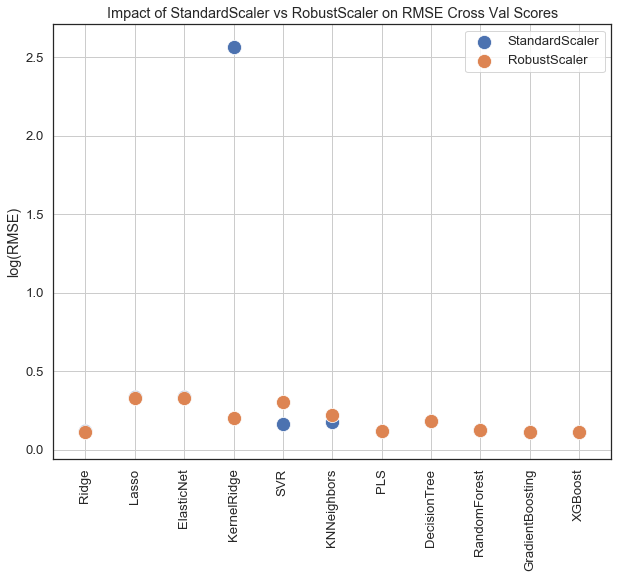

In [96]:
fig, ax = plt.subplots()
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - StandardScaler"]), s=200, label="StandardScaler", ax=ax)
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - RobustScaler"]), s=200, label="RobustScaler", ax=ax)
plt.title("Impact of StandardScaler vs RobustScaler on RMSE Cross Val Scores")
plt.ylabel("log(RMSE)")
plt.xticks(rotation=90)
ax.grid()
plt.show()

Narrowing our focus, we can look at the RMSEs for the `RobustScaler` results alone.

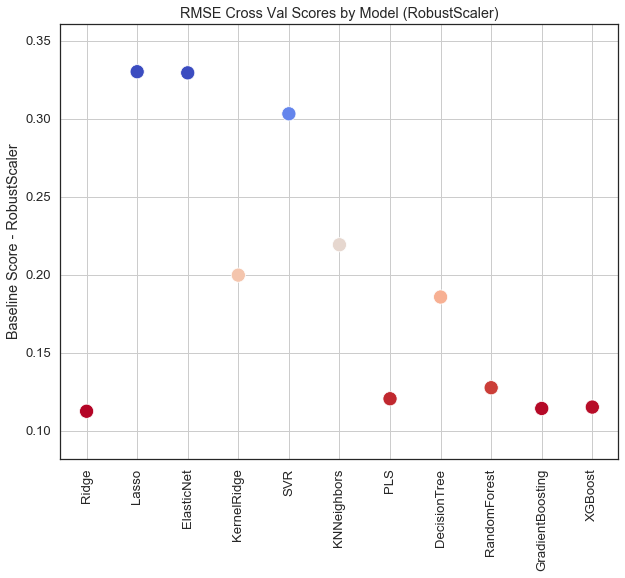

In [97]:
fig, ax = plt.subplots()
sns.scatterplot(x=hyperparam_df.index, y=np.log1p(hyperparam_df["Baseline Score - RobustScaler"]), s=200, hue=hyperparam_df["Baseline Score - RobustScaler"], palette='coolwarm_r', legend=False, ax=ax)
plt.title("RMSE Cross Val Scores by Model (RobustScaler)")
plt.xticks(rotation=90)
ax.grid()
plt.show()

**Optimize Hyperparameters**

The goal of hyperparameter optimization is to improve the performance of our models (decrease bias). However, we have to be careful not to overfit the data.

In [110]:
def tune_hyperparameters_direct(model, params, scaler):
    grid = GridSearchCV(model, params, n_jobs=4, cv=5, scoring="neg_mean_squared_error", refit=True, verbose=3)
    pipeline = make_pipeline(scaler, grid)
    pipeline.fit(train, y)
    return grid.best_params_, np.round(np.sqrt(-grid.best_score_), 3)

In [117]:
# https://www.kaggle.com/vikassingh1996/extensive-data-preprocessing-and-modeling
# https://stackoverflow.com/questions/43366561/use-sklearns-gridsearchcv-with-a-pipeline-preprocessing-just-once

def tune_hyperparameters(model_name):
    grid = GridSearchCV(params[model_name]["Model"], param_grid=params[model_name]["Params"], 
                        n_jobs=4, cv=5, scoring="neg_mean_squared_error", refit=True, verbose=3)
    pipeline = make_pipeline(params[model_name]["Scaler"], grid)
    pipeline.fit(train, y)
    
    best_params = grid.best_params_
    best_score = np.round(np.sqrt(-grid.best_score_), 3)
    
    hyperparam_df.loc[model_name, "Best Score"] = best_score
    hyperparam_df.loc[model_name, "Best Params"] = [best_params]
    
    return best_params, best_score

In [103]:
def print_results(model_name):
    print("{} =>\nBest RMSE = {}".format(model_name, hyperparam_df.loc[model_name, "Best Score"]))
    print("Best Params = {}".format(hyperparam_df.loc[model_name, "Best Params"]))

In [70]:
# Ridge
ridge_param_grid = {"alpha": np.arange(10, 30, 2), 
                    "random_state": [SEED]}

# Optimized Params:
ridge_param_grid = {'alpha': [20], 'random_state': [42]}

In [71]:
# Lasso
alpha = [0.0001, 0.0002, 0.0003, 0.0004, 0.00045, 0.0005, 0.0006, 0.0008, 
         0.001, 0.002, 0.004, 0.005, 0.006, 0.007, 0.008, 0.01]
lasso_param_grid = {"alpha": alpha, 
                    "random_state": [SEED]}

# Optimized Params:
lasso_param_grid = {'alpha': [0.0006], 'random_state': [42]}

In [72]:
# ElasticNet
elastic_param_grid = {"alpha": [0.0001, 0.0002, 0.0003, 0.01, 0.1, 2], 
                      "l1_ratio": [0.2, 0.85, 0.95, 0.98, 1], 
                      "random_state": [SEED]}

# Optimized Params:
elastic_param_grid = {'alpha': [0.0003], 'l1_ratio': [1], 'random_state': [42]}

In [73]:
# KernelRidge
kernel_param_grid = {"alpha": [0.25, 0.4, 0.5, 0.6, 0.75, 1], 
                     "kernel": ["linear", "polynomial"], "degree": [2, 3], "coef0": [1.5, 2, 3]}

# Optimized Params:
kernel_param_grid = {'alpha': [0.25], 'coef0': [1.5], 'degree': [2], 'kernel': ['linear']}

In [90]:
# Random Forest Regressor
rf_param_grid = {"n_estimators": [50, 100, 500, 1000], 
                "max_depth": [1, 2, 3, 4, 5],
                "min_samples_leaf": [2, 3, 4],
                "min_samples_split": [3, 4, 5],
                "random_state": [SEED]}

# Optimized Params:
rf_param_grid = {'max_depth': [5], 'min_samples_leaf': [4], 'min_samples_split': [4], 'n_estimators': [1000], 'random_state': [42]}

In [77]:
# KNN
knn_param_grid = {"n_neighbors": [3, 4, 5, 6], 
                "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
                "leaf_size": [10, 20, 30, 40, 50],
                "p": [1, 2]}

# Optimized Params:
knn_param_grid = {'algorithm': ['auto'], 'leaf_size': [10], 'n_neighbors': [6], 'p': [1]}

In [78]:
# XGBoost
xgb_param_grid = {"min_child_weight": [1, 5, 10],
                 "gamma": [0.04, 0.14, 0.24],
                 "subsample": [0.4, 0.6, 0.8],
                 "colsampl_bytree": [0.46, 1],
                 "max_depth": [3, 4],
                 "learning_rate": [0.02, 0.05],
                 "reg_alpha": [0.4, 0.6],
                 "reg_lambda": [0.6, 0.8],
                 "n_estimators": [1000, 2000],
                 "silent": [1],
                 "nthread": [-1],
                 "random_state": [SEED]}

# Optimized Params:
xgb_param_grid = {"gamma": [0.05],
                 "subsample": [0.5],
                 "colsampl_bytree": [0.46],
                 "max_depth": [3],
                 "learning_rate": [0.05],
                 "reg_alpha": [0.5],
                 "reg_lambda": [0.9],
                 "n_estimators": [2000],
                 "silent": [1],
                 "nthread": [-1],
                 "random_state": [SEED]}

In [105]:
# Support Vector Regression
svr_param_grid = {"kernel": ["rbf"],
                 "C": [5, 10, 15, 25, 50],
                 "gamma": [0.0005, 0.0001, 0.00005]}

# Optimized Params:
svr_param_grid = {'C': [5], 'gamma': [0.0001], 'kernel': ['rbf']}

In [106]:
# Partial Least Squares Regression
pls_param_grid = {"n_components": [2, 3, 4, 5]}

# Optimized Params:
pls_param_grid = {"n_components": [4]}

In [107]:
# Gradient Boosting
gb_param_grid = {"n_estimators": [1000, 3000],
                "learning_rate": [0.01],
                "max_depth": [4],
                "loss": ["huber"],
                "max_features": ["sqrt"],
                "min_samples_leaf": [15],
                "min_samples_split": [10]}

# Optimized Params:
gb_param_grid = {"n_estimators": [3000],
                "learning_rate": [0.01],
                "max_depth": [4],
                "loss": ["huber"],
                "max_features": ["sqrt"],
                "min_samples_leaf": [15],
                "min_samples_split": [10]}

Construct a dictionary to hold our models and their hyperparameter grids:

In [130]:
params = {}
for model in models:
    params[model[0]] = {"Model": model[1], "Scaler": StandardScaler()}
    
params["Ridge"]["Params"] =  ridge_param_grid
params["Lasso"]["Params"] =  lasso_param_grid
params["ElasticNet"]["Params"] =  elastic_param_grid
params["KernelRidge"]["Params"] =  kernel_param_grid
params["RandomForest"]["Params"] =  rf_param_grid
params["KNNeighbors"]["Params"] =  knn_param_grid
params["XGBoost"]["Params"] = xgb_param_grid
params["SVR"]["Params"] = svr_param_grid
params["PLS"]["Params"] = pls_param_grid
params["DecisionTree"]["Params"] = dt_param_grid
params["GradientBoosting"]["Params"] = et_param_grid

params["Ridge"]["Scaler"] =  RobustScaler()
params["KernelRidge"]["Scaler"] =  RobustScaler()

In [118]:
models_to_evaluate = ["Ridge", "Lasso", "ElasticNet", "KernelRidge", "RandomForest", "KNNeighbors", "XGBoost", "SVR", "PLS", "DecisionTree", "GradientBoosting"]
for model_name in models_to_evaluate:
    tune_hyperparameters(model_name)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.7s remaining:    1.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.3s finished
D:\PROGRAMS\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.06044722094629762, tolerance: 0.022825630709970138
  positive)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    4.2s remaining:    6.3s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    5.7s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    6.7s remaining:   10.1s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:   11.8s finished
D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.2s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Done  36 tasks      | elapsed:    9.8s
[Parallel(n_jobs=4)]: Done 132 tasks      | elapsed:   34.8s
[Parallel(n_jobs=4)]: Done 292 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done 516 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 804 tasks      | elapsed:  8.9min
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed: 11.0min finished


In [126]:
hyperparam_df.sort_values(by="Best Score")

,Baseline Score - StandardScaler,Baseline Score - RobustScaler,Best Score,Best Params
Ridge,0.127,0.119,0.114,"{'alpha': 20, 'random_state': 42}"
XGBoost,0.122,0.122,0.115,"{'colsampl_bytree': 0.46, 'gamma': 0.05, 'lear..."
GradientBoosting,0.121,0.121,0.117,"{'max_depth': 1, 'min_samples_leaf': 3, 'min_s..."
Lasso,0.396,0.391,0.118,"{'alpha': 0.0006, 'random_state': 42}"
SVR,0.175,0.354,0.118,"{'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}"
PLS,0.128,0.128,0.119,{'n_components': 4}
ElasticNet,0.396,0.390,0.121,"{'alpha': 0.0003, 'l1_ratio': 1, 'random_state..."
RandomForest,0.136,0.136,0.152,"{'max_depth': 5, 'min_samples_leaf': 4, 'min_s..."
KernelRidge,12.022,0.221,0.164,"{'alpha': 0.25, 'coef0': 1.5, 'degree': 2, 'ke..."
KNNeighbors,0.196,0.245,0.175,"{'algorithm': 'auto', 'leaf_size': 10, 'n_neig..."


The optimized scores can help us decide which models to use for our final averaged predictions.

My selections:

* Ridge + `RobustScaler`
* XGBoost + `StandardScaler`
* GradientBoosting + `StandardScaler`
* SVR + `StandardScaler`
* KernelRidge + `RobustScaler`
* RandomForest + `StandardScaler`

In [125]:
# Copying values, to save time when re-running
#hyperparam_df["Baseline Score - StandardScaler"].values
#hyperparam_df["Baseline Score - RobustScaler"].values
#hyperparam_df["Best Score"].values
#hyperparam_df["Best Params"].values

In [66]:
baseline_score_standardscaler = [ 0.127,  0.396,  0.396, 12.022,  0.175,  0.196,  0.128,  0.204, 0.136,  0.121,  0.122]
baseline_score_robustscaler = [0.119, 0.391, 0.39 , 0.221, 0.354, 0.245, 0.128, 0.204, 0.136, 0.121, 0.122]
best_scores = [0.114, 0.118, 0.121, 0.164, 0.118, 0.175, 0.119, 0.186, 0.152, 0.117, 0.115]
best_params = [{'alpha': 20, 'random_state': 42},
       {'alpha': 0.0006, 'random_state': 42},
       {'alpha': 0.0003, 'l1_ratio': 1, 'random_state': 42},
       {'alpha': 0.25, 'coef0': 1.5, 'degree': 2, 'kernel': 'linear'},
       {'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'},
       {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'p': 1},
       {'n_components': 4},
       {'min_samples_leaf': 4, 'min_samples_split': 3, 'random_state': 42},
       {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1000, 'random_state': 42},
       {'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1000, 'random_state': 42},
       {'colsampl_bytree': 0.46, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'nthread': -1, 'random_state': 42, 'reg_alpha': 0.5, 'reg_lambda': 0.9, 'silent': 1, 'subsample': 0.5}]

hyperparam_df = pd.DataFrame(index=[m[0] for m in models])

hyperparam_df["Baseline Score - StandardScaler"] = baseline_score_standardscaler
hyperparam_df["Baseline Score - RobustScaler"] = baseline_score_robustscaler
hyperparam_df["Best Score"] = best_scores
hyperparam_df["Best Params"] = best_params

In [134]:
for p in hyperparam_df["Best Params"]:
    print(p)

{'alpha': 20, 'random_state': 42}
{'alpha': 0.0006, 'random_state': 42}
{'alpha': 0.0003, 'l1_ratio': 1, 'random_state': 42}
{'alpha': 0.25, 'coef0': 1.5, 'degree': 2, 'kernel': 'linear'}
{'C': 5, 'gamma': 0.0001, 'kernel': 'rbf'}
{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 6, 'p': 1}
{'n_components': 4}
{'min_samples_leaf': 4, 'min_samples_split': 3, 'random_state': 42}
{'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 1000, 'random_state': 42}
{'max_depth': 1, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 1000, 'random_state': 42}
{'colsampl_bytree': 0.46, 'gamma': 0.05, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 2000, 'nthread': -1, 'random_state': 42, 'reg_alpha': 0.5, 'reg_lambda': 0.9, 'silent': 1, 'subsample': 0.5}


**Create Averaged Model Ensemble**

In [136]:
hyperparam_df.loc["XGBoost", "Best Params"]

{'colsampl_bytree': 0.46,
 'gamma': 0.05,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 2000,
 'nthread': -1,
 'random_state': 42,
 'reg_alpha': 0.5,
 'reg_lambda': 0.9,
 'silent': 1,
 'subsample': 0.5}

In [139]:
final_model_names = ["Ridge", "KernelRidge", "RandomForest", "XGBoost", "SVR", "GradientBoosting"]
final_models = [ridge, kr, rf, xgb, svr, gb]

ridge = Ridge(**hyperparam_df.loc["Ridge", "Best Params"])
kr = KernelRidge(**hyperparam_df.loc["KernelRidge", "Best Params"])
rf = RandomForestRegressor(**hyperparam_df.loc["RandomForest", "Best Params"], n_jobs=-1)
xgb = XGBRegressor(**hyperparam_df.loc["XGBoost", "Best Params"], n_jobs=-1, objective="reg:squarederror")
svr = SVR(**hyperparam_df.loc["SVR", "Best Params"])
gb = GradientBoostingRegressor(**hyperparam_df.loc["GradientBoosting", "Best Params"])

predictions = pd.DataFrame()

for model in zip(final_model_names, final_models):
    scaler = params[model[0]]["Scaler"]
    
    pipeline = make_pipeline(scaler, model[1])
    pipeline.fit(train, y)
    preds = pd.Series(np.expm1(pipeline.predict(test)))
    predictions = pd.concat([predictions, preds], axis=1, sort=False)

D:\PROGRAMS\Anaconda\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [142]:
predictions.columns = final_model_names
predictions.head()

,Ridge,KernelRidge,RandomForest,XGBoost,SVR,GradientBoosting
0,116188.648025,122915.393010,123209.096439,122548.515625,121584.391840,120163.436758
1,154279.866567,159664.109633,150996.421464,161351.453125,162545.066361,163208.700141
2,175728.788500,173056.674522,169357.704112,187951.531250,180021.934494,181629.275813
3,197901.351041,200765.344188,177129.967537,192445.765625,200624.480651,191949.813561
4,192021.553097,198405.932385,199429.058102,191788.750000,197365.637144,199838.619694


In [ ]:
stacked_model = StackedCVRegressor(regressors=(ridge, kern))

In [71]:
elnt = ElasticNet(**hyperparam_df.loc["ElasticNet", "Best Params"])
lasso = Lasso(**hyperparam_df.loc["Lasso", "Best Params"])
xgb = XGBRegressor(**hyperparam_df.loc["XGBoost", "Best Params"], n_jobs=-1, objective="reg:squarederror")
kr = KernelRidge(**hyperparam_df.loc["KernelRidge", "Best Params"])

predictions = pd.DataFrame()

for model in [elnt, lasso, xgb, kr]:
    pipeline = make_pipeline(RobustScaler(), model)
    pipeline.fit(train, y)
    preds = pd.Series(np.expm1(pipeline.predict(test)))
    predictions = pd.concat([predictions, preds], axis=1, sort=False)

AttributeError: 'ElasticNet' object has no attribute 'transform'

In [122]:
p = predictions.mean(axis=1)
output = generate_output(p, save=True)

In [82]:
averaged_models.models[0].fit(train,y).predict(test)

array([11.69122591, 11.92709087, 12.08589894, ..., 12.03801347,
       11.66039692, 12.31970029])

In [69]:
# https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, train, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)
            
        return self
    
    def predict(self, train):
        predictions = np.column.stack([
            model.predict(test) for model in self.models_
        ])
        
        return np.mean(predictions, axis=1)